# Predicting Hospital Length of Stay of General Surgical Patients

### Part 3

In [1]:
#Import libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

from scipy.stats import chi2_contingency  
from scipy.stats import norm

In [2]:
#importing csv 

df2=pd.read_csv("data_cleaned.csv")
df2.head(3)

,surgery_time_min,icu_days,age,sex,height,weight,asa,emergency_op,op_type,surgical_approach,ane_type,preop_htn,preop_dm,preop_hb,preop_plt,preop_gluc,preop_cr,iv_line,arterial_line,central_line,intraop_urine,rbc_transfusion,ffplasma_transfusion,intraop_crystalloid,intraop_colloid,propofol,midazolam,fentanyl,vecuronium,ephedrine,phenylephrine,Epinephrine,calcium chloride,LOS_days,LOS
0,192.0,0,elderly age,M,160.2,67.5,2.0,0,Colorectal,Open,General,1,0,14.1,189.0,134.0,0.82,Right forearm,Left radial,unknown,300.0,0,0,350.0,0,120,0.0,100,0,10,0,0,0,7.0,prolonged
1,262.0,0,elderly age,M,167.3,54.8,2.0,0,Stomach,Open,General,0,0,10.2,251.0,88.0,0.86,Left forearm,unknown,unknown,700.0,0,0,800.0,0,150,0.0,0,0,20,0,0,0,17.0,prolonged
2,73.0,0,elderly age,M,169.1,69.7,1.0,0,Biliary/Pancreas,Videoscopic,General,0,0,14.2,373.0,87.0,1.18,Left forearm,unknown,unknown,180.0,0,0,200.0,0,0,0.0,0,0,0,0,0,0,0.0,short


In [3]:
#Function to prepare X

def prepare_X(X):
    X=pd.get_dummies(X, columns=X.select_dtypes(include='object').columns, drop_first=True)   #first category to be dropped during the encoding process to avoid multicollinearity and reduce the dimensionality of the encoded data.
    return X

In [4]:
# Function to prepare target y

def prepare_y(y):
    encoder = OrdinalEncoder(categories=[['short', 'medium', 'prolonged']])
    ordinal_data = encoder.fit_transform(y)
    return pd.DataFrame(ordinal_data, columns=['LOS'])

In [5]:
def upsampling_smote(X, y):
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
    return X, y

# Random Forest Classifier Optimization

### Hyperparameter Tuning

Before build the parameter grid, I want to see the best range of values (k) to insert in the **n-estimators** parameter, which is the number of trees to build.

In [6]:
#Preparing X and y 

X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

#Upsampling 
X, y = upsampling_smote(X, y)


#X-y split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify=y ensures stratified split, maintaining the class distribution (short, medium and prolonged) in both y_train and y_test.

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3954, 76)
(1695, 76)
(3954, 1)
(1695, 1)


Text(0, 0.5, 'Testing Accuracy')

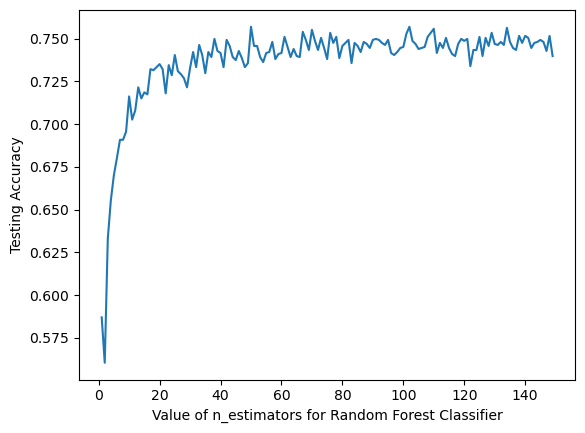

In [9]:
scores =[]   # empty list to store the scores

for k in range(1, 150):  #between 1 and 150 trees
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

# plot the relationship between k and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 150), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [10]:
# At which nr of estimators we get the best accuracy?

max_accuracy = max(scores)
max_index = scores.index(max_accuracy)
print("max_score:", max_accuracy)
print("n_estimator:", max_index)

# we get the maximum score of 0.75 with 49 trees.

max_score: 0.7569321533923303
n_estimator: 49


#### Grid Search for Parameter Tuning with Cross Validation

In [7]:
# dictionary with parameters to put inside the grid for the search space to explore all the possible combinations of hyperparameters.

param_grid = {
    'criterion': ['gini', 'entropy'],  #The function to measure the quality of a split
    'n_estimators': [40, 60, 70, 100], #The number of trees to build before taking the maximum voting
    'min_samples_split': [2, 4],  #The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5], #The minimum number of samples required to be at a leaf node.
    'max_features': ['sqrt', 'auto', 'log2'], #The max number of features RF is allowed to try in individual tree and use when looking for the best split
    'max_samples': [None, 0.3, 0.5, 0.8],  #the fraction of the original dataset that is given to any individual tree
    'max_depth': [3, 5, 7, None]  # tree's depth (crucial to prevent overfitting)
    }

In [8]:
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=10, return_train_score=True, scoring = "accuracy")   #Using 10-Fold cross validation as well to find the best combination.

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, None],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'max_samples': [None, 0.3, 0.5, 0.8],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4],
                         'n_estimators': [40, 60, 70, 100]},
             return_train_score=True, scoring='accuracy')

In [10]:
#Check the best set of parameters returned

best_params = grid_search.best_params_

print(best_params)
print("Best score: {:.2f}".format(grid_search.best_score_)) # Check the best score, which is the average of all cv folds for a single combination of the parameters I specify in the param_grid. 

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.74


The accuracy of the model is: 74.69
[[477  20  68]
 [ 28 441  96]
 [ 92 125 348]]
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       565
         1.0       0.75      0.78      0.77       565
         2.0       0.68      0.62      0.65       565

    accuracy                           0.75      1695
   macro avg       0.74      0.75      0.74      1695
weighted avg       0.74      0.75      0.74      1695



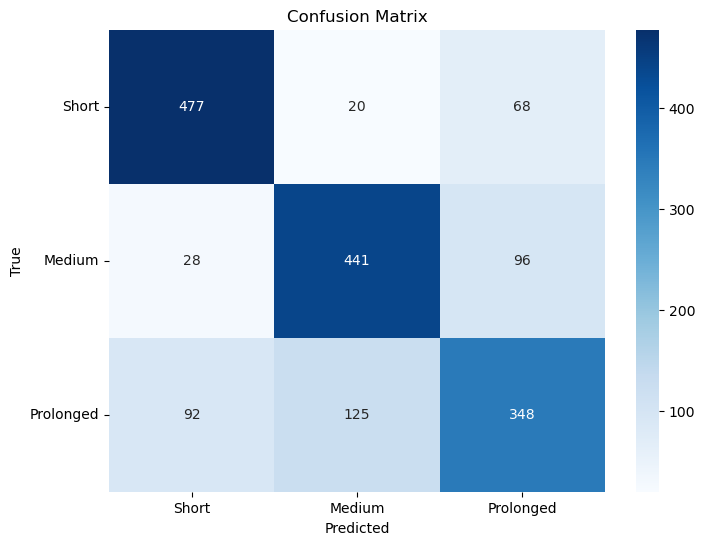

In [11]:
#  Training the model using the best parameters from the grid_search

X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

X, y = upsampling_smote(X, y)

rf_best = grid_search.best_estimator_   
rf_best.fit(X_train, y_train)
predictions = rf_best.predict(X_test)

# Model Performance

print("The accuracy of the model is: {:4.2f}".format(rf_best.score(X_test, y_test)*100))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

color = 'Blues' # changing colors of confusion matrix

classes = ['Short', 'Medium', 'Prolonged'] #changing the labels

# Function to plot the confusion matrix
def plot_custom_confusion_matrix(cm, classes, color):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=color)

    plt.yticks(ticks=[0.5, 1.5, 2.5], labels= classes, rotation=0) #position of the labels in y


    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=classes, rotation=0) # position of the labels in x

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot the confusion matrix
plot_custom_confusion_matrix(cm, classes, color)

- Short Length: 477 Predicted correctly and 120 predicted incorrectly.


- Medium Length : 441 predicted correctly and 145 predicted incorrectly.


- Prolonged Length: 348 Predicted correctly and 164 incorrectly.


When looking at the Confusion Matrix and Metrics I can conclude the model is particularly effective in correctly predicting **Short Length of Stay** class, as evident from the higher precision (80%)  when comparing to Medium (75%) and Prolonged Lengths (68%). This means that the model can more effectively distinguish instances of the Short Length of Stay class from other classes.

##  Model Evaluation

#### Using Cross-validation technique to obtain a more reliable estimate of the Random Forest Classifier performance

"Cross validation is a technique to measure the performance of a model through resampling. Cross validation does multiple train test splits ensuring all observations appear in the training and testing sets therefore the evaluation metric is considered to be more reliable when comparing to only 1 train test split"

In [12]:
# with 10 cross validation folds

cv_scores = cross_val_score(rf_best, X_train, y_train, cv=10, scoring='accuracy')  #only on the training set
lower, upper = norm.interval(alpha=0.9, loc=np.mean(cv_scores), scale=np.std(cv_scores))
print('lower=%.3f, upper=%.3f' % (lower, upper))

lower=0.711, upper=0.749


It means that with 90% confidence, the true accuracy is expected to be between 69% and 75%.

### AUC-ROC Curve

#### Plotting ROC Curve with AUC metric to evaluate model performance

In [13]:
#Preparing X and y 
X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

#Upsampling 
X, y = upsampling_smote(X, y)

#X-y split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

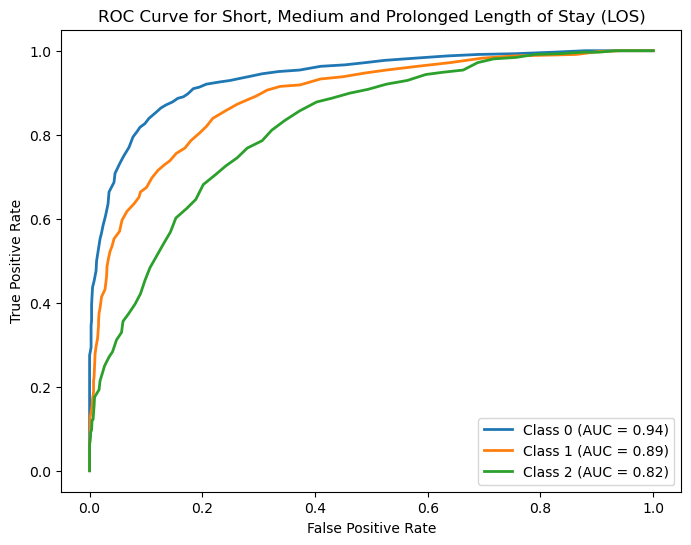

In [15]:
# Binarize target to be able to plot ROC curve with a multiclass target

classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)


# OneVsRestClassifier - it allows to perform multi-class classification using binary classifiers

clf = OneVsRestClassifier(rf_best)  #OneVsRestClassifier() to use the binarize target, because target is multiclass.

# Train the classifier
clf.fit(X_train, y_train_bin)

# Get the predicted probabilities for each class on the test data
y_probs = clf.predict_proba(X_test)


# Compute the ROC curve and ROC AUC for each class

fpr = dict() #To store the false positives rate for each class
tpr = dict() # To store the true positives rate for each class
roc_auc = dict() #To store the auc metric for each class
n_classes = y_train_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Ploting the ROC curves

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Short, Medium and Prolonged Length of Stay (LOS)')
plt.legend(loc="lower right")
plt.show()

### Conclusion

- Random Forest Classifier has shown promising results and efficency at predicting different Hospital Lengths for a patient (Short, Medium or Prolonged). When looking at the evaluation metrics we conclude the model achieved higher precision (0.80) in predicting **Short Lengths** when comparing to Medium (0.75) and Prolonged lengths (0.68) with an overall accuracy of 74%. 


- Analysing the ROC Curve and AUC scores we can see that the model demonstrates ability in differentiating between the three classes: Short, Medium, and Prolonged Lengths of Stay.All classes have a AUC score above 0.5 which means there is high chance that the Random Forest Classifier model is able to discriminate between True positives and False positives for each class, therefore if it predicts for example Short Length for a patient, there is a high change of being correct and not actually be Medium or Prolonged.


- However, model's true effectiveness can only be determined by assessing its performance on real-world unseen patient data. Given that the model was trained on data where synthetic samples were generated for the minority classes (using SMOTE) to address the class imbalance issue, particular attention should be given to its performance on the "Medium" and "Prolonged" Length of Stay classes.

